In [2]:
# Importing packages
using Lux
using Zygote
using Optimization
using OptimizationOptimisers
using Random
using Statistics
using DifferentialEquations
using Plots
using ComponentArrays
using NNlib

## The goal is to identify unknown ODE parameters and partial ODE equation components themselves using MLPs

The following equations will be used to generate the noisy data. These equations are a classic SIR model:

$ \frac{d}{dt}S = -\beta S $

$ \frac{d}{dt}I = \beta S - \gamma I $

$ \frac{d}{dt}R = + \gamma I $

There will be log-normal noise added to simulate a real world scenario

In [22]:
struct SIR_params
    β::Float32
    γ::Float32
end

# SIR model method for DifferentialEquations call 
function SIR_model!(du, u, p::SIR_params, t)
    S, I, R = u
    du[1] = -p.β * S * I 
    du[2] =  p.β * S * I - p.γ * I
    du[3] =  p.γ * I
end

# SIR model non mutating function method to calculate NN RHS
# This is another way to define a function
SIR_model(y::AbstractMatrix{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1, :] .* y[2, :]        
    dI = p.β .* y[1,:] .* y[2, :] - p.γ .* y[2, :]
    dR = p.γ .* y[2, :]                         
    permutedims(hcat(dS, dI, dR))
end

# For a non-matrix input 
SIR_model(y::AbstractVector{<:Real}, p::SIR_params) = begin

    dS = - p.β .* y[1] .* y[2]        
    dI = p.β .* y[1] .* y[2] - p.γ .* y[2]
    dR = p.γ .* y[2]                         
    permutedims(hcat(dS, dI, dR))
end

function SIR_model(y::AbstractVecOrMat{<:Real}, p::SIR_params, gPred::AbstractVector{<:Real})
    # g has to be an output of g_MLP(t, θ_g) predictions
    dS = gPred
    dI = p.β .* y[1] .* y[2] - p.γ .* y[2]
    dR = p.γ .* y[2]                         
    permutedims(hcat(dS, dI, dR))
end

# Fast default RNG. Does not get messed up with a global RNG
rng = Random.MersenneTwister(42)

# Start with our true known parameters
true_SIR_par = SIR_params(0.30, 0.1)
t_span = (0.0f0, 60.0f0)
N_obs = 101

# Collect seems to turn an iterable into an array
t_obs_array = range(t_span[1], t_span[2], length=N_obs) |> collect
u0 = [0.999, 0.001, 0.0]

# solve the ODE to get a solution object
prob = DifferentialEquations.ODEProblem(SIR_model!, u0, t_span, true_SIR_par)
sol = DifferentialEquations.solve(
    prob,
    DifferentialEquations.Tsit5();
    saveat = t_obs_array
)
# Convert the solution object into an Array
sol_ = Array(sol)

# multiplicative % noise via lognormal, unbiased & positive 
noise_pct = 0.2
ε = Random.randn(rng, size(sol_)...)
noisy_data = sol_ .* exp.(noise_pct .* ε .- 0.5 * noise_pct^2) 
noisy_data = clamp.(noisy_data, 0, Inf32)

# Convert to Float32 to keep everyone happy
t_train = Float32.(t_obs_array)
Y_train = Float32.(noisy_data)
y0_obs  = Y_train[:, 1]     # IC for penalty

Y_train_std = Statistics.std(Y_train, dims=2);


### Visualize the generated data

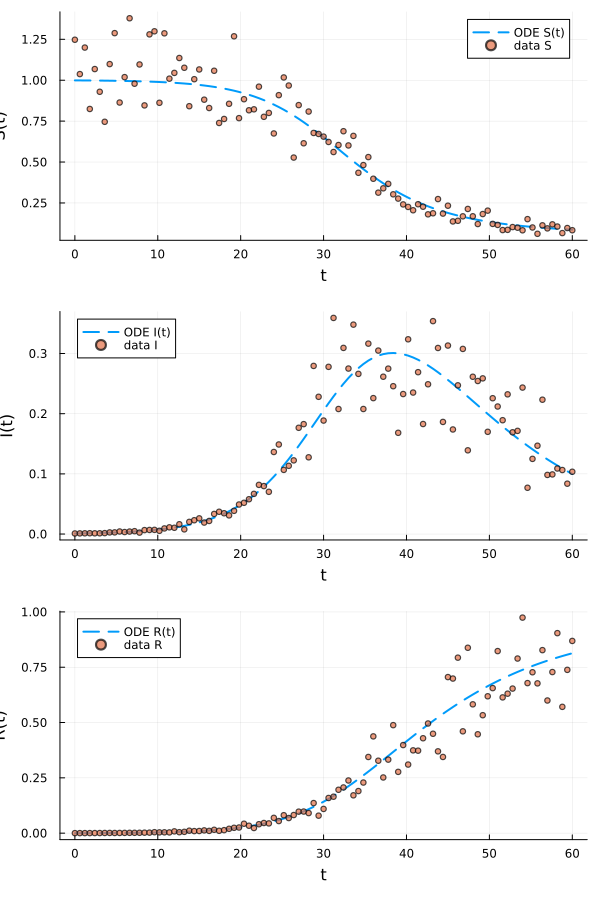

In [4]:

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))


# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)

### The Neural Network Architecture
Let us define two neural networks. One that predicts the states and the other that learns missing physics.

They are expected to look like:

The state predictor
$u(t; \theta_u)$

Let us say that the we do not know the physics behind the dynamics of S. The model formulation will look like:

$\frac{d}{dt}S = g(t; \theta_g)$

$ \frac{d}{dt}I = \beta S - \gamma I $

$ \frac{d}{dt}R = + \gamma I $

where $g(t; \theta_g)$ is an MLP expected to learn this physics


In [43]:
# Defining the state predicting neural network
State_MLP = Lux.Chain(
    Lux.Dense(1, 10, tanh),
    Lux.Dense(10, 10, tanh),
    Lux.Dense(10, 3, NNlib.softplus) # forces outputs to be positive
)

ps_StateMLP, st_StateMLP = Lux.setup(rng, State_MLP)

# defining the physics learner for S
g_MLP = Lux.Chain(
    Lux.Dense(1, 5, tanh),
    Lux.Dense(5, 1, tanh) # This output can be negative
)

ps_gMLP, st_gMLP = Lux.setup(rng, g_MLP)
guess_SIR_params = SIR_params(0.1,0.1)

λ_ic = 1.0f0*100
λ_ode = 1.0f0*2
λ_Data = 5.5f0

# Assemble all the trainable parameters
trainable_params = ComponentArrays.ComponentArray(
    StateMLP = ps_StateMLP,
    gMLP = ps_gMLP,
    ODE_par = (
        β = guess_SIR_params.β,
        γ = guess_SIR_params.γ
    ),
    hyperparams = (
        λ_ode = λ_ode
        )
)



ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[-0.9813747; 0.769165; … ; 0.7268814; 2.2775126;;], bias = Float32[0.97465086, 0.5169804, -0.24398804, 0.17276835, -0.10369897, 0.10527277, 0.41273284, -0.018407106, -0.6500313, 0.100805044]), layer_2 = (weight = Float32[-0.8891301 0.15084979 … 0.445847 0.125473; 0.09903736 -0.17378461 … -0.74763864 -0.2615732; … ; 0.8306884 -0.63332784 … -0.2518586 -0.6106805; 0.28399894 -0.63051474 … 0.33021092 -0.45769453], bias = Float32[-0.2824933, -0.28672814, 0.2845592, -0.23527081, 0.3122304, -0.0035868215, 0.16732317, 0.1709633, 0.25462845, 0.21274728]), layer_3 = (weight = Float32[-0.26200268 -0.18078785 … -0.27691337 -0.48807424; 0.25258914 -0.53567785 … -0.34941724 0.38282654; 0.24940047 -0.46506295 … 0.54160637 -0.2940135], bias = Float32[0.10247721, -0.26825517, 0.15991725])), gMLP = (layer_1 = (weight = Float32[1.0275311; -0.6491333; … ; 1.9885576; -0.96929306;;], bias = Float32[-0.7689049, 0.4244411, 0.9785254, -0.33656216,

In [44]:
# Helper functions to calculate MSE loss
# Almost always the normalized version is to be used
function MSE(ŷ, y)
    # Basic MSE 
    Statistics.mean(abs2, vec(ŷ .- y))
end

function MSE(ŷ, y, denom)
    # MSE Normalized to a pre-specified denominator. 
    # This is expected to be the std of the corresponding data vector 
    t = vec((ŷ - y)./denom)
    Statistics.mean(abs2, t)
end


t_dense = Float32.(range(t_train[begin], t_train[end], length=200) |> collect)

ctx_stage1 = (
    State_MLP = State_MLP,
    st_StateMLP = st_StateMLP,
    t_train = t_train,
    Y_train = Y_train,
    Y_train_std = Y_train_std,
    y0_obs = y0_obs,
    λ_ic = λ_ic,
    
)
ctx_stage2 = (
    State_MLP = State_MLP,
    st_StateMLP = st_StateMLP,
    g_MLP = g_MLP,
    st_gMLP = st_gMLP,
    t_train = t_train,
    Y_train = Y_train,
    Y_train_std = Y_train_std,
    #λ_ode = λ_ode,
    t_dense = t_dense,
    λ_Data = λ_Data 
)

# Supervised loss to fit the state MLP to the data
function loss_supervised(ps, ctx)
    #ctx is a named tuple holding everything non-trainable
    State_MLP = ctx.State_MLP
    st_StateMLP = ctx.st_StateMLP
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    y0_obs = ctx.y0_obs
    λ_ic = ctx.λ_ic
    Y_train_std = ctx.Y_train_std


    smodel = Lux.StatefulLuxLayer(State_MLP, ps.StateMLP, st_StateMLP) 
    ŷ = smodel(t_train')
    data_mse = MSE(ŷ, Y_train, Y_train_std)
    ic_mse = Statistics.mean(abs2, ŷ[:,1] .- y0_obs)
      
    return data_mse + ic_mse * λ_ic
end


# Unsupervised loss to regularize the state MLP towards an ODE model
function loss_unsupervised(ps, ctx) 
    State_MLP = ctx.State_MLP
    st_StateMLP = ctx.st_StateMLP
    t_train = ctx.t_train
    Y_train = ctx.Y_train
    g_MLP = ctx.g_MLP
    st_gMLP = ctx.st_gMLP
    #λ_ode = ctx.λ_ode
    Y_train_std = ctx.Y_train_std
    λ_Data  = ctx.λ_Data 
    
    smodel = Lux.StatefulLuxLayer(State_MLP, ps.StateMLP, st_StateMLP)
    gmodel = Lux.StatefulLuxLayer(g_MLP, ps.gMLP, st_gMLP)

    SIR_par = SIR_params(
        trainable_params.ODE_par.β,
        trainable_params.ODE_par.γ
    )

    f = tn -> begin
    ŷ_NN = smodel([tn])
    ĝ_NN = gmodel([tn])
    f_ŷ_NN = SIR_model(ŷ_NN, SIR_par, ĝ_NN)
    dNNdt_tn = Zygote.jacobian(smodel, [tn])[1]
    MSE(f_ŷ_NN, dNNdt_tn, Y_train_std)
    end

    ode_mse = mean(f.(ctx.t_dense))

    return ode_mse*ps.hyperparams + λ_Data * MSE(smodel(t_train'), Y_train, Y_train_std)

end



loss_unsupervised (generic function with 1 method)

In [45]:
optfun1 = Optimization.OptimizationFunction(
    (θ, p) -> loss_supervised(θ, p),
    Optimization.AutoZygote()
)
prob1 = Optimization.OptimizationProblem(
    optfun1, 
    trainable_params, 
    ctx_stage1
)
res1 = Optimization.solve(
    prob1,
    OptimizationOptimisers.Adam(1e-03);
    maxiters = 3_000
)

trainable_params_post_stage1 = res1.u

optfun2 = Optimization.OptimizationFunction(
    (θ, p) -> loss_unsupervised(θ, p),
    Optimization.AutoZygote()
)

prob2 = Optimization.OptimizationProblem(
    optfun2,
    trainable_params_post_stage1, 
    ctx_stage2
)

res2 = Optimization.solve(
    prob2, 
    OptimizationOptimisers.Adam(5e-04); 
    maxiters=5_000
)
ps_trained = res2.u

ComponentVector{Float32}(StateMLP = (layer_1 = (weight = Float32[-0.07107494; -0.04444103; … ; 0.045682453; 1.5757513;;], bias = Float32[1.7879014, 1.291964, -0.53155595, 0.5431648, -0.121379755, 0.34699056, 0.4430111, -0.019941207, -1.972697, -0.21605377]), layer_2 = (weight = Float32[-1.2128999 -0.6576169 … 2.1203454 -0.14992732; 0.75646484 0.6884246 … -1.4634916 -0.17687014; … ; 0.7266415 -0.40973443 … -0.28601623 -0.7656649; -0.33067217 -1.1596754 … 0.5825664 -0.21046981], bias = Float32[-0.5119472, -0.18989877, 0.40339825, 0.054214284, 0.4613889, 0.6291621, 0.31544784, -0.20452364, 0.24313156, 0.24941003]), layer_3 = (weight = Float32[-0.2999157 -0.002123776 … -0.585187 -1.0956243; 0.5562531 -0.6347912 … 0.07300202 0.50434065; 0.3570988 -1.3638246 … 0.35289356 0.56665975], bias = Float32[-0.070270635, -0.99191064, -0.43236184])), gMLP = (layer_1 = (weight = Float32[0.7905335; -0.22088946; … ; 2.655541; -0.944132;;], bias = Float32[-1.6892354, 0.7343443, 0.93457204, 0.4620484, 0.73

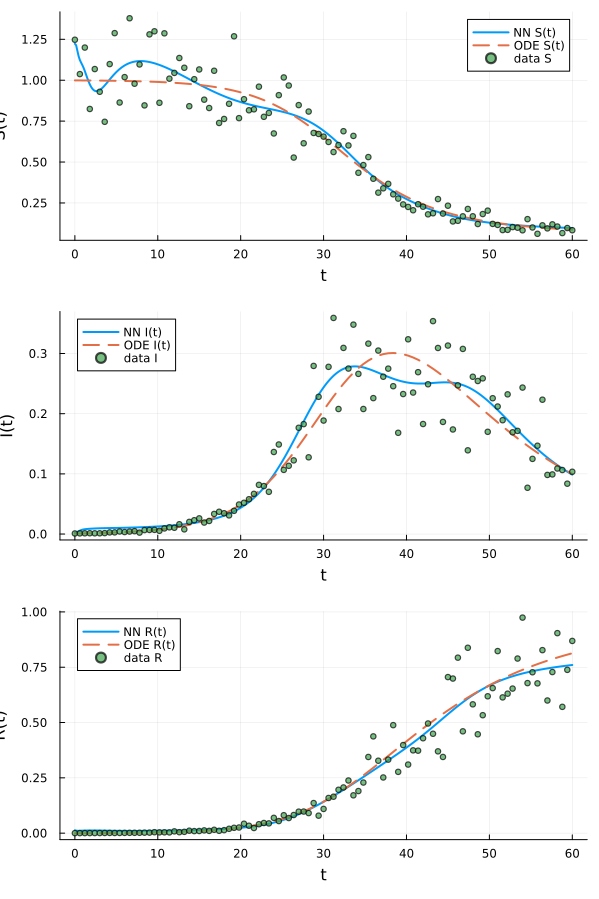

In [47]:
# Build a stateful model bound to the trained params
smodel = Lux.StatefulLuxLayer(State_MLP, ps_trained.StateMLP, st_StateMLP)
#gmodel = Lux.StatefulLuxLayer(g_MLP, ps_trained.gMLP, st_gMLP)

# A smooth time grid for plotting the NN curve
t_plot = Float32.(collect(range(t_span[1], t_span[2], length=400)))

# NN predictions on the smooth grid (3×N)
ŷ_plot = smodel(permutedims(t_plot))  # 1×N input expected; returns 3×N

# Split true, NN, and noisy series
S_true, I_true, R_true = sol_[1, :], sol_[2, :], sol_[3, :]
S_nn,   I_nn,   R_nn   = vec(ŷ_plot[1, :]), vec(ŷ_plot[2, :]), vec(ŷ_plot[3, :])
S_noisy, I_noisy, R_noisy = Y_train[1, :], Y_train[2, :], Y_train[3, :]

# Panel 1: S(t)
p1 = Plots.plot(t_plot, S_nn; label = "NN S(t)", linewidth = 2)
Plots.plot!(p1, t_obs_array, S_true; label = "ODE S(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p1, t_train, S_noisy; label = "data S", ms = 3, alpha = 0.7)
Plots.xlabel!(p1, "t")
Plots.ylabel!(p1, "S(t)")

# Panel 2: I(t)
p2 = Plots.plot(t_plot, I_nn; label = "NN I(t)", linewidth = 2)
Plots.plot!(p2, t_obs_array, I_true; label = "ODE I(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p2, t_train, I_noisy; label = "data I", ms = 3, alpha = 0.7)
Plots.xlabel!(p2, "t")
Plots.ylabel!(p2, "I(t)")

# Panel 3: R(t)
p3 = Plots.plot(t_plot, R_nn; label = "NN R(t)", linewidth = 2)
Plots.plot!(p3, t_obs_array, R_true; label = "ODE R(t)", linestyle = :dash, linewidth = 2)
Plots.scatter!(p3, t_train, R_noisy; label = "data R", ms = 3, alpha = 0.7)
Plots.xlabel!(p3, "t")
Plots.ylabel!(p3, "R(t)")

# Combine panels
plt = Plots.plot(p1, p2, p3; layout = (3, 1), size = (600, 900))
display(plt)

#Plots.savefig(plt, "Results/2025-10-13_NNfitWithODELoss.svg")


In [ ]:
ps_trained

ComponentVector{Float32,SubArray...}(β = 1.0f0, γ = 1.0f0)

In [39]:
Zygote.gradient(x -> loss_unsupervised(x, ctx_stage2), trainable_params)

((StateMLP = (layer_1 = (weight = Float32[-0.038466983; -0.10112432; … ; -150.48466; -0.23976633;;], bias = Float32[0.5221871, -1.1139446, 0.2735211, 0.0465831, -1.2954397, -2.2854066, 1.4290457, -5.853662, -12.726332, 1.2125512]), layer_2 = (weight = Float32[73.10897 -72.833595 … 49.575104 -73.06997; -2.903611 2.9306943 … -1.896993 2.8957784; … ; 0.68022335 -1.0281821 … 0.2097561 -0.613717; -20.168491 19.333004 … -14.027771 20.130789], bias = Float32[72.813545, -2.8352897, -21.93097, 10.573166, 2.360586, -2.4520106, -4.069662, 52.344032, 0.09077591, -19.923508]), layer_3 = (weight = Float32[-0.37082416 0.7665367 … 0.9075452 0.784251; 36.140026 -161.81929 … -189.98816 -166.26439; 0.995823 -4.0511045 … -4.7910047 -4.2012386], bias = Float32[-0.9514334, 189.37941, 4.856615])), gMLP = (layer_1 = (weight = Float32[0.01132262; -0.039936572; … ; 0.01056123; 0.002688352;;], bias = Float32[0.027921664, -0.040689018, 0.0025962219, 0.020216059, 0.009657416]), layer_2 = (weight = Float32[-0.52292

In [48]:
ps_trained.ODE_par

ComponentVector{Float32,SubArray...}(β = 0.1f0, γ = 0.1f0)

In [42]:
smodel([40f0])

3-element Vector{Float32}:
 0.5048672
 0.07419651
 0.40753633